In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

In [2]:
DATASET_COLUMNS=['sentiment','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
data = pd.read_csv('/content/drive/MyDrive/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
data.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
data = data.dropna()
data.reset_index(inplace=True)

## **Exploratory** **Data** **Analysis**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   index      1600000 non-null  int64 
 1   sentiment  1600000 non-null  int64 
 2   ids        1600000 non-null  int64 
 3   date       1600000 non-null  object
 4   flag       1600000 non-null  object
 5   user       1600000 non-null  object
 6   text       1600000 non-null  object
dtypes: int64(3), object(4)
memory usage: 85.4+ MB


In [5]:
data.dtypes

index         int64
sentiment     int64
ids           int64
date         object
flag         object
user         object
text         object
dtype: object

In [6]:
data['sentiment'].unique()

array([0, 4])

In [7]:
data['sentiment'].nunique()

2

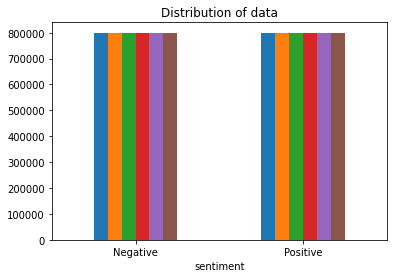

In [8]:
# Plotting the distribution for dataset.
ax = data.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiments = list(data['text']), list(data['sentiment'])

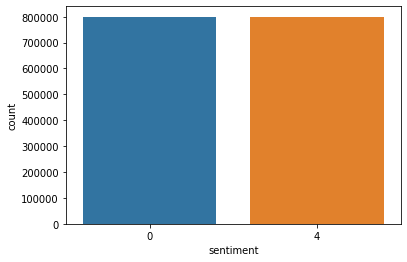

In [9]:
sns.countplot(x='sentiment', data=data)

# **Text Preprocessing**

In [10]:
dirtyData=data[['text','sentiment']]

In [11]:
dirtyData['sentiment'] = dirtyData['sentiment'].replace(4,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
dirtyData['sentiment'].unique()

array([0, 1])

In [13]:
positive = dirtyData[dirtyData['sentiment'] == 1]
negative = dirtyData[dirtyData['sentiment'] == 0]

In [14]:
#taking 50 000 data points so as to run the model quicker with limited computing resources
positive =positive.iloc[:int(25000)]
negative =negative.iloc[:int(25000)]

In [15]:
dataset = pd.concat([positive, negative])

In [16]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

24995    is sad that it is raining... no softball for m...
24996                               last day of vacation. 
24997    good morning! its a beautiful day, too bad i'm...
24998    night all. love yas. hahahahahah btw... vodka ...
24999       why do i have to go back to school tomorrow?? 
Name: text, dtype: object

In [17]:
import nltk
import re
from nltk.corpus import stopwords

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwords.words('english')])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [20]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

24995                           sad raining softball today
24996                                    last day vacation
24997    good morning beautiful day bad im gonna spendi...
24998        night all love yas hahahahahah btw vodka evil
24999                              go back school tomorrow
Name: text, dtype: object

In [21]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

24995                           sad raining softball today
24996                                    last day vacation
24997    good morning beautiful day bad im gonna spendi...
24998        night all love yas hahahahahah btw vodka evil
24999                              go back school tomorrow
Name: text, dtype: object

In [22]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

24995                           sad raining softball today
24996                                    last day vacation
24997    good morning beautiful day bad im gonna spendi...
24998        night all love yas hahahahahah btw vodka evil
24999                              go back school tomorrow
Name: text, dtype: object

In [23]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

24995                           sad raining softball today
24996                                    last day vacation
24997    good morning beautiful day bad im gonna spendi...
24998        night all love yas hahahahahah btw vodka evil
24999                              go back school tomorrow
Name: text, dtype: object

In [24]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].tail()

24995                      [sad, raining, softball, today]
24996                                [last, day, vacation]
24997    [good, morning, beautiful, day, bad, im, gonna...
24998    [night, all, love, yas, hahahahahah, btw, vodk...
24999                         [go, back, school, tomorrow]
Name: text, dtype: object

In [25]:
dataset['text'].tail()

24995                      [sad, raining, softball, today]
24996                                [last, day, vacation]
24997    [good, morning, beautiful, day, bad, im, gonna...
24998    [night, all, love, yas, hahahahahah, btw, vodk...
24999                         [go, back, school, tomorrow]
Name: text, dtype: object

In [26]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].tail()

24995                      [sad, raining, softball, today]
24996                                [last, day, vacation]
24997    [good, morning, beautiful, day, bad, im, gonna...
24998    [night, all, love, yas, hahahahahah, btw, vodk...
24999                         [go, back, school, tomorrow]
Name: text, dtype: object

In [27]:
dataset['text']

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
                                ...                        
24995                       [sad, raining, softball, today]
24996                                 [last, day, vacation]
24997     [good, morning, beautiful, day, bad, im, gonna...
24998     [night, all, love, yas, hahahahahah, btw, vodk...
24999                          [go, back, school, tomorrow]
Name: text, Length: 50000, dtype: object

In [28]:
dataset.reset_index(inplace=True)

In [29]:
def combine(data):
  return ' '.join(data)
  
dataset['text'] = dataset['text'].apply(lambda x: combine(x))
dataset.head()

,index,text,sentiment
0,800000,love healthuandpets u guys r best,1
1,800001,im meeting one besties tonight cant wait girl ...,1
2,800002,darealsunisakim thanks twitter add sunisa got ...,1
3,800003,sick really cheap hurts much eat real food plu...,1
4,800004,lovesbrooklyn effect everyone,1


In [30]:
dataset['text2'] = dataset['text'].copy()

In [31]:
x1 = dataset['text2']
y1 = dataset['sentiment']

# **Traditional Machine learning with TFIDF vectorizer**

In [32]:
from sklearn.model_selection import train_test_split
x_train1,x_test1,y_train1,y_test1 = train_test_split(x1,y1,test_size = 0.3,random_state = 42)

In [33]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(x_train1)


TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [34]:
x_train1 = vectoriser.transform(x_train1)
x_test1  = vectoriser.transform(x_test1)

### **BernoulliNB**

In [35]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report

In [36]:
bayesModel = BernoulliNB()
bayesModel.fit(x_train1, y_train1)
y_pred1 = bayesModel.predict(x_test1)

In [37]:
y_pred1

array([0, 1, 0, ..., 0, 0, 0])

In [38]:
print(classification_report(y_test1, y_pred1))

              precision    recall  f1-score   support

           0       0.73      0.78      0.75      7474
           1       0.77      0.71      0.73      7526

    accuracy                           0.74     15000
   macro avg       0.75      0.74      0.74     15000
weighted avg       0.75      0.74      0.74     15000



In [39]:
confusion_matrix(y_test1, y_pred1)

array([[5846, 1628],
       [2214, 5312]])

### **Support** **Vector** **Machine**

In [40]:
SVCmodel = LinearSVC()
SVCmodel.fit(x_train1, y_train1)
y_pred2 = SVCmodel.predict(x_test1)

In [41]:
print(classification_report(y_test1, y_pred2))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      7474
           1       0.76      0.74      0.75      7526

    accuracy                           0.75     15000
   macro avg       0.75      0.75      0.75     15000
weighted avg       0.75      0.75      0.75     15000



In [42]:
confusion_matrix(y_test1, y_pred2)

array([[5722, 1752],
       [1950, 5576]])

In [43]:
#best model is the support vector machine at 75% accuracy

In [44]:
# using the whole dataset for the vectoriser
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(x1)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [45]:
import pickle

# saving the vectoriser
with open('tfidf.pkl','wb') as f:
    pickle.dump(vectoriser,f)

In [46]:
total_x = vectoriser.transform(x1)

In [47]:
#using the whole dataset to train the model
SVCmodel_final = LinearSVC()
SVCmodel_final.fit(total_x,y1)

LinearSVC()

In [48]:
# saving the model
with open('model.pkl','wb') as f:
    pickle.dump(SVCmodel_final,f)